# Compare fMRI and MEG RDMS Across Subjects and Image Categories

In [1]:
import scipy
import scipy.io
from scipy.io import loadmat
import numpy as np 
import pandas as pd
from collections import Counter
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import mat73
from scipy.stats import ttest_ind

In [2]:
# load matrix function

def loadmatrix(matfile):
  """Function to load .mat files.
  Parameters
  ----------
  matfile : str
      path to `matfile` containing fMRI data for a given trial.
  Returns
  -------
  dict
      dictionary containing data in key 'vol' for a given trial.
  """
  try:
    f = h5py.File(matfile)
  except (IOError, OSError):
    return scipy.io.loadmat(matfile)
  else:
    return {name: np.transpose(f.get(name)) for name in f.keys()}

In [4]:
# load fMRI data
fMRI_file = '/Users/lindsey.ching/Downloads/Cichy_92_Image_Set_ROI_RDMs/92_Image_Set/target_fmri.mat'
fmri_data = loadmatrix(fMRI_file)

# extract the brain region fields
EVC_RDMs = fmri_data['EVC_RDMs']
IT_RDMs = fmri_data['IT_RDMs']

In [76]:
# load MEG data 

MEG_RDMs = loadmatrix('/Users/lindsey.ching/Downloads/Cichy_92_Image_Set_ROI_RDMs/MEG_decoding_RDMs.mat')['MEG_decoding_RDMs']
print(MEG_RDMs.shape)

(16, 2, 1301, 92, 92)


### Compare Differences Across Subjects (fMRI)

In [144]:
# Hextract upper triangular elements of RDMs
#def extract_upper_triangular(matrix):
#    return matrix[np.triu_indices_from(matrix, k=1)]

def get_lowertriangular(rdm):
  """
  returns lower triangular part of the matrix
  """
  num_conditions = rdm.shape[0]
  return rdm[np.tril_indices(num_conditions, -1)]

# compare RDMs between subjects
def compare_between_subjects(rdms, modality_name):
    num_subjects = rdms.shape[0]  
    print(num_subjects)
    subject_rdms = [get_lowertriangular(rdms[i]) for i in range(num_subjects)]
    

    # Perform pairwise t-tests between subjects
    p_values = np.zeros((num_subjects, num_subjects))
    for i in range(num_subjects):
        for j in range(num_subjects):

            t_stat, p_val = ttest_ind(subject_rdms[i], subject_rdms[j])
            p_values[i, j] = np.round(p_val, 6)

    
    print(f"P-values for {modality_name} between subjects:")
    print(p_values)
    return p_values

In [145]:
# compare fMRI RDMs between subjects
evc_p_values_subjects = compare_between_subjects(EVC_RDMs, 'fMRI (EVC)')
it_p_values_subjects = compare_between_subjects(IT_RDMs, 'fMRI (IT)')

15
P-values for fMRI (EVC) between subjects:
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.07240e-02 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 0.0000

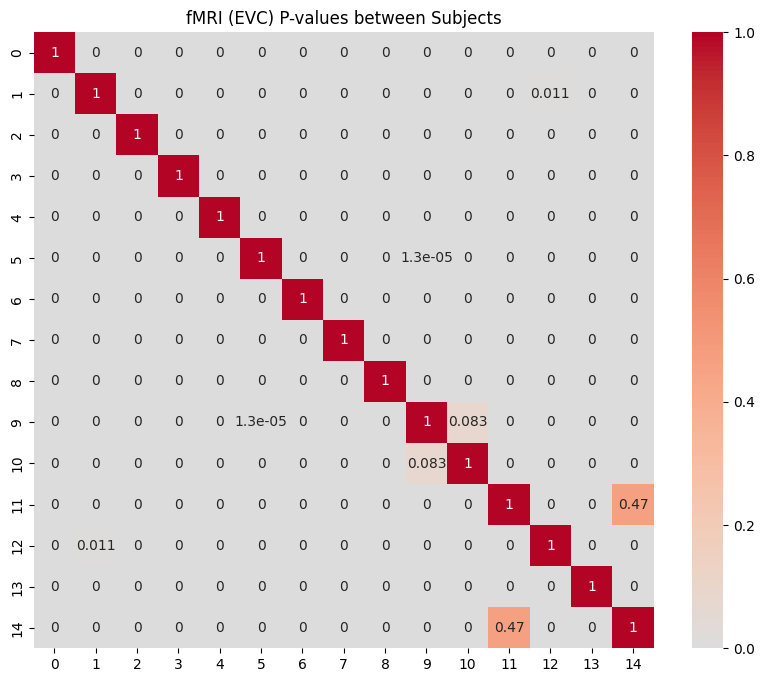

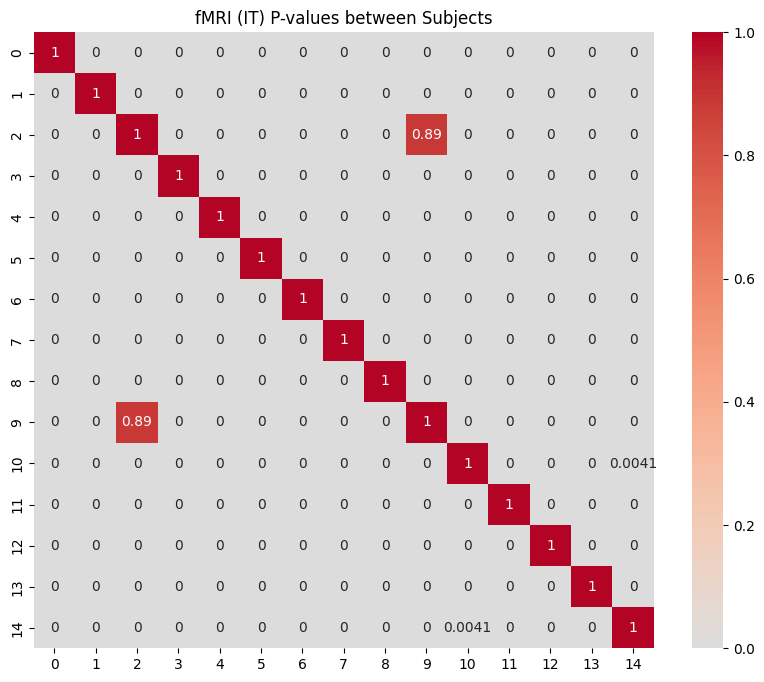

In [89]:
# heatmap for p-values between subjects
plt.figure(figsize=(10, 8))
sns.heatmap(evc_p_values_subjects, annot=True, cmap='coolwarm', center=0)
plt.title('fMRI (EVC) P-values between Subjects')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(it_p_values_subjects, annot=True, cmap='coolwarm', center=0)
plt.title('fMRI (IT) P-values between Subjects')
plt.show()

### Compare Differences Across Subjects Using Rolling Average  (MEG) - Session 1

In [151]:
MEG_RDMs.shape

(16, 2, 1301, 92, 92)

In [235]:
def compute_rolling_average(rdms, window_size=65):
    """
    Computes a rolling average of the RDMs over a specified window size.
    """
    num_subjects, _, num_time_points, num_conditions, _ = rdms.shape
    first_session_rdms = rdms[:, 0, :, :]

    averaged_rdms = np.zeros((num_subjects, int(np.floor(num_time_points/window_size)), num_conditions, num_conditions))


    for i in range(num_subjects):
        #for t in range(num_time_points - window_size + 1):
        for t in range(int(np.floor(num_time_points/window_size))):
            # Average over the window
            averaged_rdms[i, t] = np.mean(first_session_rdms[i, t:t + window_size], axis=0)

    return averaged_rdms

# compare RDMs between subjects using a rolling average
def compare_between_subjects(rdms, modality_name, window_size=65):
    num_subjects = rdms.shape[0]
    num_time_points = rdms.shape[2]
    num_conditions = rdms.shape[3]


    averaged_rdms = compute_rolling_average(rdms, window_size)

    #iInitialize an array to store p-values for each averaged time point
    #num_averaged_time_points = num_time_points - window_size + 1
    num_averaged_time_points = int(np.floor(num_time_points/window_size))
    p_values_all_time_points = np.zeros((num_averaged_time_points, num_subjects, num_subjects))

    for t in range(num_averaged_time_points):
        # extract lower triangular parts for each subject at averaged time point t
        subject_rdms = [get_lowertriangular(averaged_rdms[i, t]) for i in range(num_subjects)]

        # perform pairwise t-tests between subjects for averaged time point t
        for i in range(num_subjects):
            for j in range(num_subjects):
                t_stat, p_val = ttest_ind(subject_rdms[i], subject_rdms[j])
                p_values_all_time_points[t, i, j] = np.round(p_val, 3)

    # print p-values for each averaged time point
    for t in range(num_averaged_time_points):
        print(f"P-values for {modality_name} between subjects at averaged time point {t}:")
        print(p_values_all_time_points[t])

    return p_values_all_time_points

In [236]:
MEG_p_values = compare_between_subjects(MEG_RDMs, "MEG")

P-values for MEG between subjects at averaged time point 0:
[[1.    0.001 0.    0.002 0.001 0.    0.    0.    0.    0.    0.    0.101
  0.    0.    0.077 0.   ]
 [0.001 1.    0.001 0.917 0.757 0.001 0.987 0.    0.    0.053 0.101 0.
  0.011 0.    0.    0.   ]
 [0.    0.001 1.    0.001 0.    0.948 0.    0.044 0.    0.104 0.061 0.
  0.371 0.073 0.    0.006]
 [0.002 0.917 0.001 1.    0.854 0.001 0.924 0.    0.    0.05  0.094 0.
  0.011 0.    0.    0.   ]
 [0.001 0.757 0.    0.854 1.    0.    0.751 0.    0.    0.015 0.036 0.
  0.002 0.    0.    0.   ]
 [0.    0.001 0.948 0.001 0.    1.    0.    0.053 0.    0.092 0.053 0.
  0.338 0.087 0.    0.007]
 [0.    0.987 0.    0.924 0.751 0.    1.    0.    0.    0.033 0.072 0.
  0.006 0.    0.    0.   ]
 [0.    0.    0.044 0.    0.    0.053 0.    1.    0.027 0.    0.    0.
  0.002 0.792 0.    0.421]
 [0.    0.    0.    0.    0.    0.    0.    0.027 1.    0.    0.    0.
  0.    0.011 0.    0.179]
 [0.    0.053 0.104 0.05  0.015 0.092 0.033 0.    0.   

In [237]:
# 65 ms window size, 20 windows, 16 subjects
MEG_p_values.shape

(20, 16, 16)

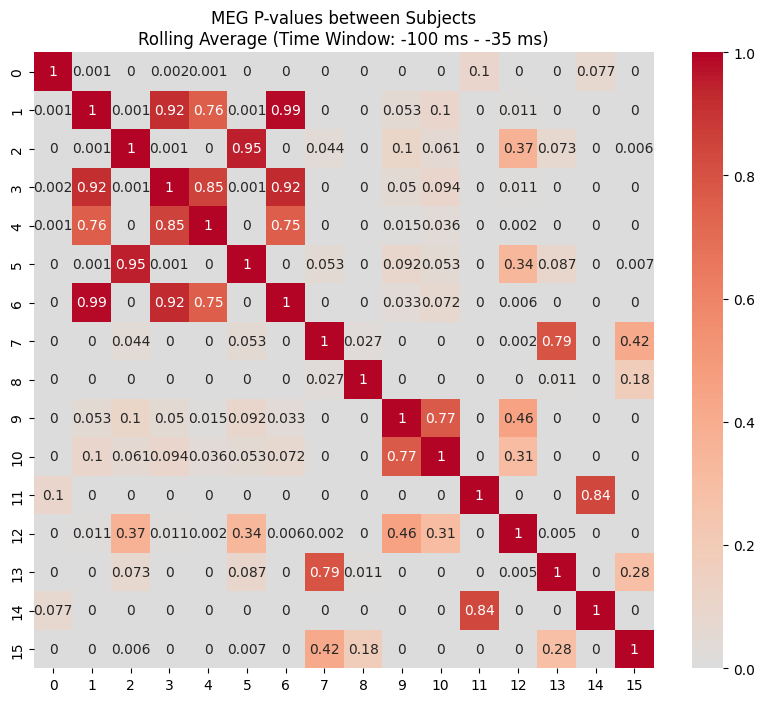

In [242]:
# first window
plt.figure(figsize=(10, 8))
sns.heatmap(MEG_p_values[0], annot=True, cmap='coolwarm', center=0)
plt.title('MEG P-values between Subjects\nRolling Average (Time Window: -100 ms - -35 ms)')
plt.show()

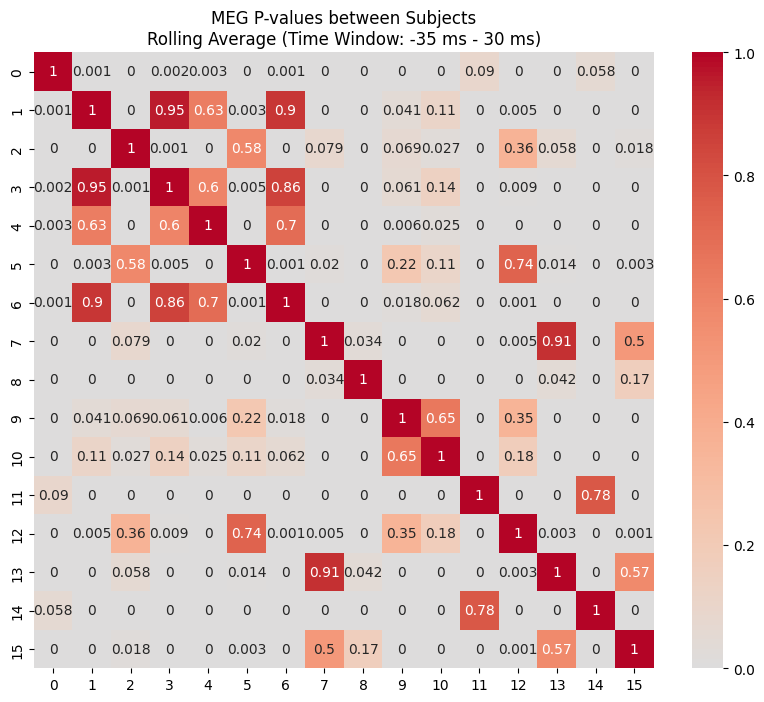

In [243]:
# second window
plt.figure(figsize=(10, 8))
sns.heatmap(MEG_p_values[1], annot=True, cmap='coolwarm', center=0)
plt.title('MEG P-values between Subjects\nRolling Average (Time Window: -35 ms - 30 ms)')
plt.show()

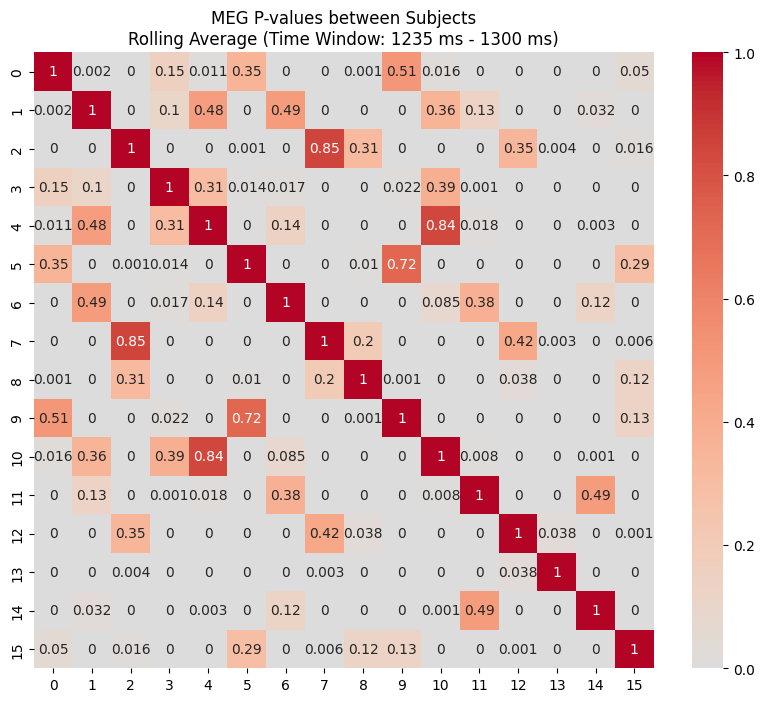

In [245]:
# last window
plt.figure(figsize=(10, 8))
sns.heatmap(MEG_p_values[-1], annot=True, cmap='coolwarm', center=0)
plt.title('MEG P-values between Subjects\nRolling Average (Time Window: 1235 ms - 1300 ms)')
plt.show()

### Compare Differences Across Image Categories (fMRI)

In [90]:
def get_stim_details(path_to_file):
  """
  acquire category names and binary features describing the Cichy images

  returns: stim_details (dict containing 5 keys: category (str), and four binary features (animate, human, natural, face)). 
                          each key holds an array giving the information for all categories
  """
  stim_dat = loadmat(path_to_file)['visual_stimuli']
  fields = ['category', 'animate', 'human', 'natural', 'face']
  stim_details = {field:[] for field in fields}
  for ii in range(92):
    for jj, field in enumerate(fields):
      stim_details[field].append(stim_dat[0,ii][jj][0])
  for field in fields[1:]:
    stim_details[field] = np.array(stim_details[field]).squeeze()
  return stim_details

In [91]:
# dict of stimulus categories
stim_details = get_stim_details(path_to_file = '/Users/lindsey.ching/Downloads/Cichy_92_Image_Set_ROI_RDMs/92_Image_Set/visual_stimuli.mat')

In [92]:
# compare RDMs between image categories
def compare_between_categories(rdms, modality_name):
    num_subjects = rdms.shape[0]
    num_images = rdms.shape[1]
    
    # get unique categories as strings
    categories_list = stim_details['category']
    #unique_categories = list(set(categories_list))
    seen = set()
    unique_categories = [x for x in categories_list if not (x in seen or seen.add(x))]
    
    # initialize a dictionary to store RDMs for each category
    category_rdms = {cat: [] for cat in unique_categories}
    
    # group images into categories
    for i in range(num_subjects):
        for cat in unique_categories:
            category_indices = np.where(np.array(categories_list) == cat)[0]
            cat_rdm = rdms[i, category_indices][:, category_indices]
            category_rdms[cat].append(get_lowertriangular(cat_rdm))
    
    # perform pairwise t-tests between categories
    num_categories = len(unique_categories)
    p_values = np.zeros((num_categories, num_categories))
    
    for i, cat1 in enumerate(unique_categories):
        for j, cat2 in enumerate(unique_categories):
            cat1_rdms = np.concatenate(category_rdms[cat1])
            cat2_rdms = np.concatenate(category_rdms[cat2])
            t_stat, p_val = ttest_ind(cat1_rdms, cat2_rdms)
            p_values[i, j] = p_val
    
    print(f"P-values for {modality_name} between image categories:")
    print(p_values)
    return p_values

P-values for fMRI (EVC) between image categories:
[[1.00000000e+00 4.03323778e-18 5.93477369e-10 1.05274743e-12
  3.41723468e-04 7.85708918e-01]
 [4.03323778e-18 1.00000000e+00 1.29210130e-03 3.96001404e-02
  3.58677550e-14 1.95660173e-27]
 [5.93477369e-10 1.29210130e-03 1.00000000e+00 2.36400655e-01
  7.35708935e-05 1.27916615e-13]
 [1.05274743e-12 3.96001404e-02 2.36400655e-01 1.00000000e+00
  1.48520431e-07 5.00935867e-18]
 [3.41723468e-04 3.58677550e-14 7.35708935e-05 1.48520431e-07
  1.00000000e+00 5.80026061e-07]
 [7.85708918e-01 1.95660173e-27 1.27916615e-13 5.00935867e-18
  5.80026061e-07 1.00000000e+00]]
P-values for fMRI (IT) between image categories:
[[1.00000000e+00 5.65085778e-61 1.56134768e-10 6.19929225e-33
  3.75152458e-01 1.05626976e-01]
 [5.65085778e-61 1.00000000e+00 2.62171754e-24 1.82218487e-05
  2.39678637e-84 1.83767903e-80]
 [1.56134768e-10 2.62171754e-24 1.00000000e+00 1.15260374e-08
  6.02637690e-17 7.26193645e-18]
 [6.19929225e-33 1.82218487e-05 1.15260374e-0

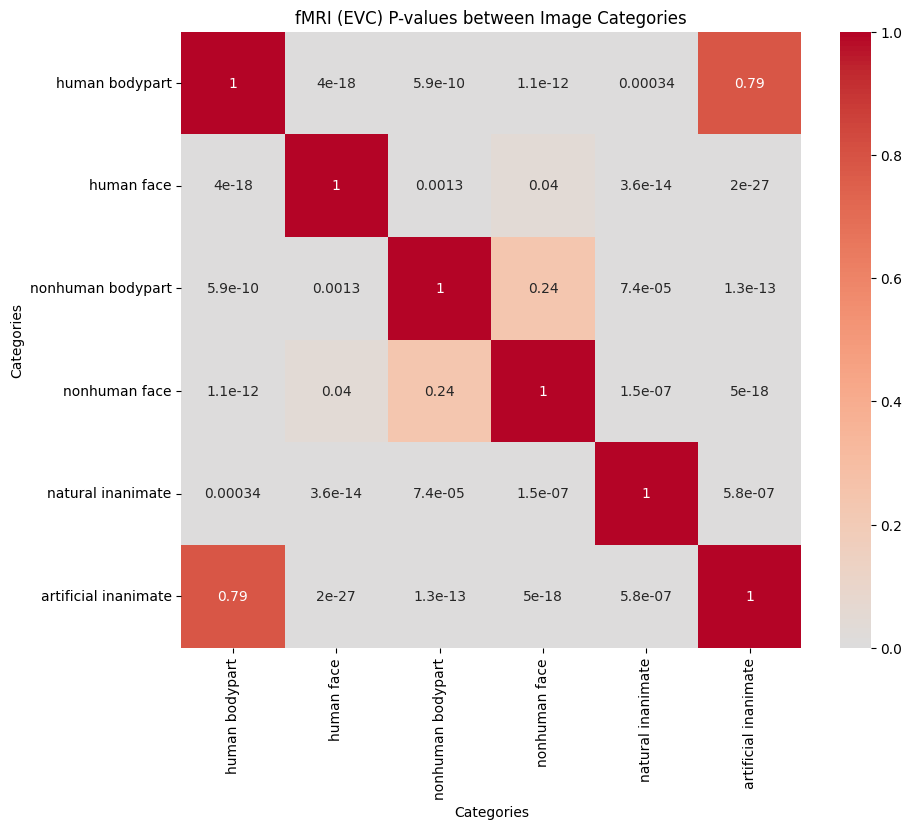

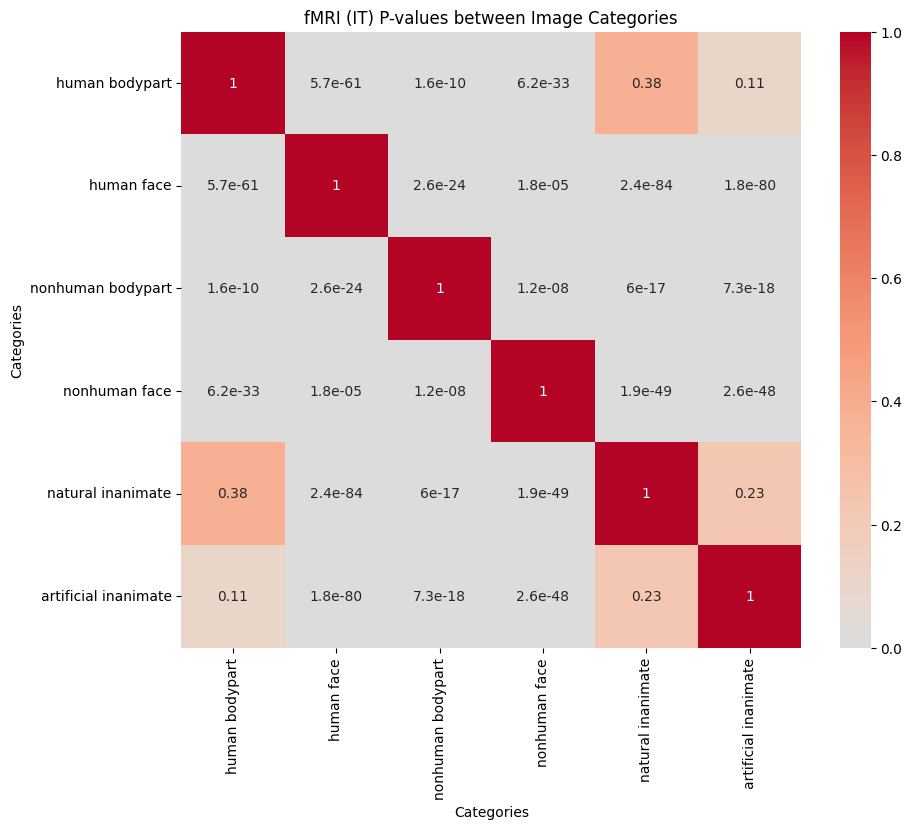

In [93]:
# compare fMRI RDMS between image categories

# get categories in order 
categories_list = stim_details['category']
seen = set()
categories = [x for x in categories_list if not (x in seen or seen.add(x))]

def plot_heatmap(p_values, categories, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(p_values, annot=True, cmap='coolwarm', center=0,
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Categories')
    plt.show()

evc_p_values_categories = compare_between_categories(EVC_RDMs,  'fMRI (EVC)')
it_p_values_categories = compare_between_categories(IT_RDMs,  'fMRI (IT)')

plot_heatmap(evc_p_values_categories, categories, 'fMRI (EVC) P-values between Image Categories')
plot_heatmap(it_p_values_categories, categories, 'fMRI (IT) P-values between Image Categories')

### Compare Differences Across Image Categories (MEG)

In [260]:
# compare MEG RDMS between image categories
MEG_averaged = compute_rolling_average(MEG_RDMs, window_size=65)

# get categories in order 
categories_list = stim_details['category']
seen = set()
categories = [x for x in categories_list if not (x in seen or seen.add(x))]

def plot_heatmap(p_values, categories, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(p_values, annot=True, cmap='coolwarm', center=0,
                xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Categories')
    plt.show()

P-values for MEG between image categories:
[[1.00000000e+00 4.11350631e-01 8.79903156e-07 3.81200925e-03
  6.44783378e-07 8.73418049e-06]
 [4.11350631e-01 1.00000000e+00 3.55768353e-05 3.81121949e-02
  7.74197267e-05 5.24088759e-04]
 [8.79903156e-07 3.55768353e-05 1.00000000e+00 3.11919797e-02
  1.85831823e-01 1.17802323e-01]
 [3.81200925e-03 3.81121949e-02 3.11919797e-02 1.00000000e+00
  1.64578693e-01 3.07234089e-01]
 [6.44783378e-07 7.74197267e-05 1.85831823e-01 1.64578693e-01
  1.00000000e+00 6.42285279e-01]
 [8.73418049e-06 5.24088759e-04 1.17802323e-01 3.07234089e-01
  6.42285279e-01 1.00000000e+00]]


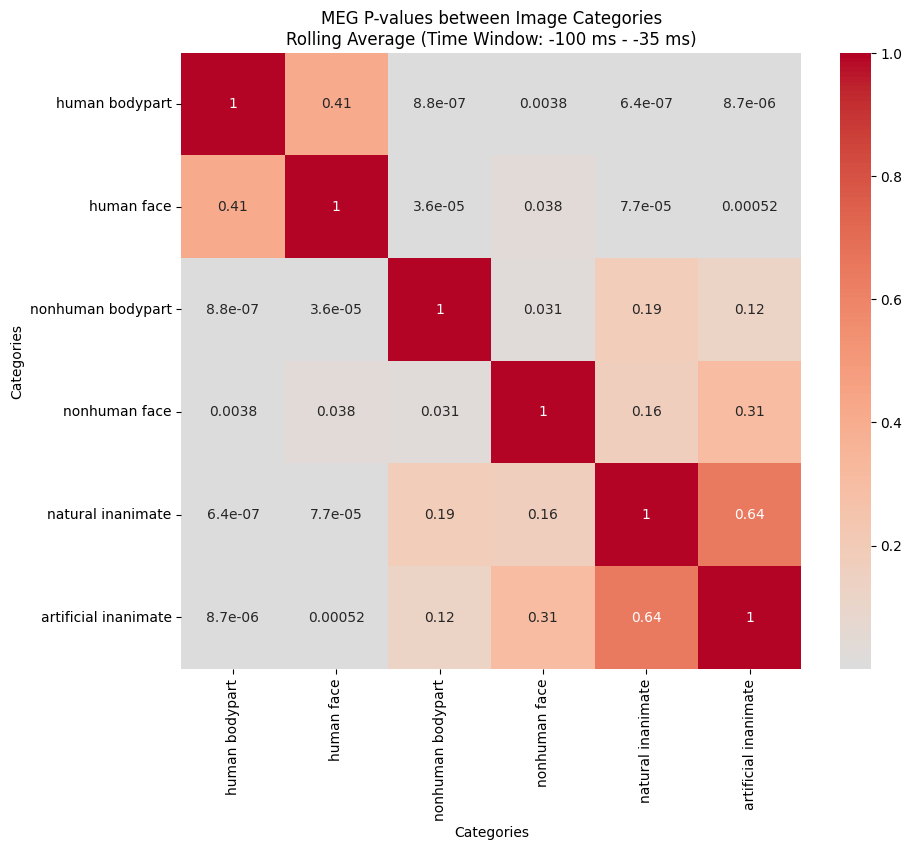

In [262]:
# first window
MEG_p_values_categories = compare_between_categories(MEG_averaged[:,0,:,:],  'MEG')
plot_heatmap(MEG_p_values_categories, categories, 'MEG P-values between Image Categories\nRolling Average (Time Window: -100 ms - -35 ms)')

P-values for MEG between image categories:
[[1.00000000e+00 4.33120728e-01 1.33733996e-06 2.57464009e-03
  4.04638114e-07 6.92898923e-06]
 [4.33120728e-01 1.00000000e+00 4.30096511e-05 2.53831110e-02
  4.33815453e-05 3.67510633e-04]
 [1.33733996e-06 4.30096511e-05 1.00000000e+00 5.12133074e-02
  2.54542348e-01 1.54203438e-01]
 [2.57464009e-03 2.53831110e-02 5.12133074e-02 1.00000000e+00
  1.86804446e-01 3.58558816e-01]
 [4.04638114e-07 4.33815453e-05 2.54542348e-01 1.86804446e-01
  1.00000000e+00 6.03140933e-01]
 [6.92898923e-06 3.67510633e-04 1.54203438e-01 3.58558816e-01
  6.03140933e-01 1.00000000e+00]]


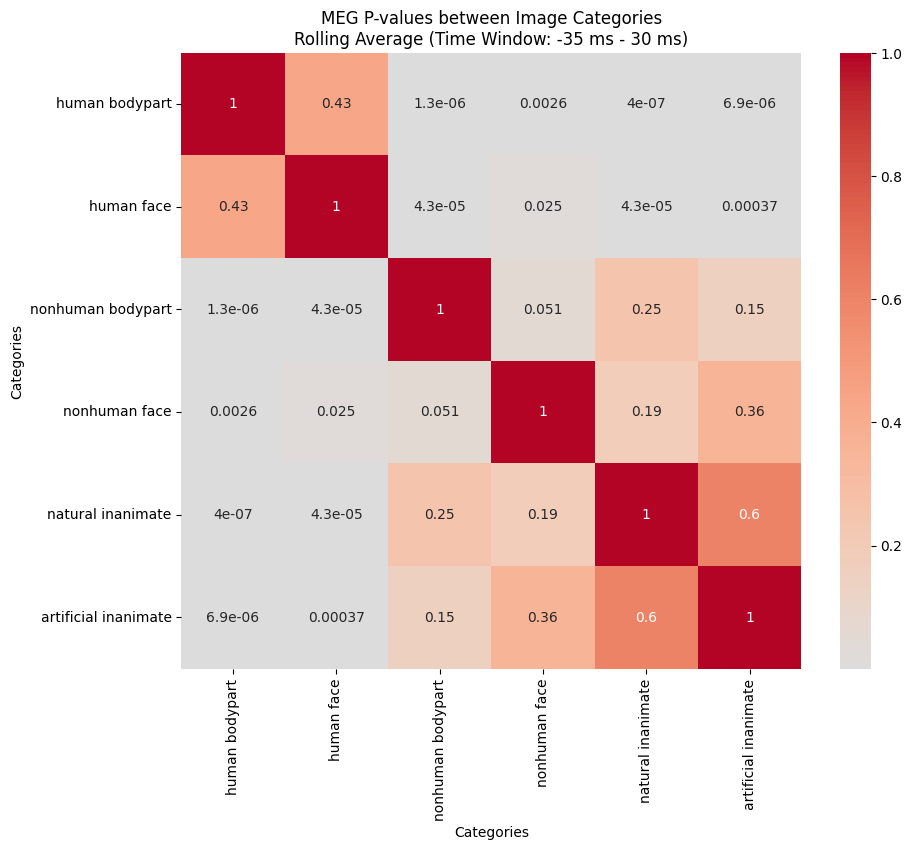

In [263]:
# second window 
MEG_p_values_categories = compare_between_categories(MEG_averaged[:,1,:,:],  'MEG')
plot_heatmap(MEG_p_values_categories, categories, 'MEG P-values between Image Categories\nRolling Average (Time Window: -35 ms - 30 ms)')

P-values for MEG between image categories:
[[1.00000000e+00 4.33120728e-01 1.33733996e-06 2.57464009e-03
  4.04638114e-07 6.92898923e-06]
 [4.33120728e-01 1.00000000e+00 4.30096511e-05 2.53831110e-02
  4.33815453e-05 3.67510633e-04]
 [1.33733996e-06 4.30096511e-05 1.00000000e+00 5.12133074e-02
  2.54542348e-01 1.54203438e-01]
 [2.57464009e-03 2.53831110e-02 5.12133074e-02 1.00000000e+00
  1.86804446e-01 3.58558816e-01]
 [4.04638114e-07 4.33815453e-05 2.54542348e-01 1.86804446e-01
  1.00000000e+00 6.03140933e-01]
 [6.92898923e-06 3.67510633e-04 1.54203438e-01 3.58558816e-01
  6.03140933e-01 1.00000000e+00]]


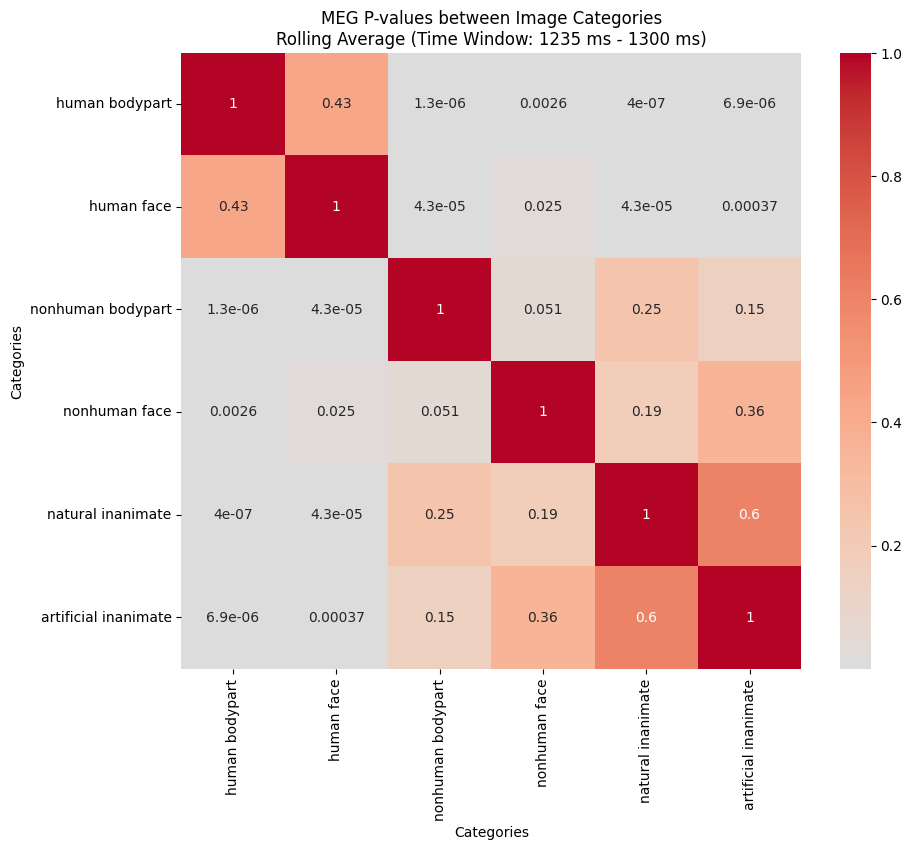

In [264]:
# last window
MEG_p_values_categories = compare_between_categories(MEG_averaged[:,1,:,:],  'MEG')
plot_heatmap(MEG_p_values_categories, categories, 'MEG P-values between Image Categories\nRolling Average (Time Window: 1235 ms - 1300 ms)')